# Figure 7
This notebook performs the VAE modelling and related analysis as shown in Figure 7. Note that the input data required is produced in `vae_data.ipynb` which can be found in the `2_Workbooks` folder.

In [1]:
import os
print(os.getcwd())
import sys

# add scripts folder to the system path
sys.path.insert(0, '../1_scripts')

import random
import numpy as np
import pandas as pd
import torch

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

import torch
import torch.nn as nn

from tqdm import trange

from utils import train, evaluate
from dataLoader import setup_data_loaders

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)

#assert pyro.__version__.startswith('1.8.5')
pyro.distributions.enable_validation(False)
pyro.set_rng_seed(0)
smoke_test = 'CI' in os.environ

pyro.clear_param_store()

data_dir = "/Users/rl275/Projects/bb_longread/VAE/0_data/"
paralogs = "panaroo"
x_dim = 1987 # gene count for panaroo run
z_dim = 32 
hidden_dim = 256

input_file = f"vae_{paralogs}.pkl" # this file is produced in `vae_data.ipynb` in the Workbooks folder of the main code
vaedata_file = f"data_{paralogs}.pt"
vaelabels_file = f"labels.csv"


/Users/rl275/Projects/bb_longread/VAE/3_workbooks


/Users/rl275/miniconda3/envs/ml_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Process Data

In [2]:
# read in pickled dataframe of gene presence with genotype labels
df = pd.read_pickle(data_dir + input_file)

# separate into model data and labels
label_cols = ["Isolate", "RST", "OspC", "MLST"]
data_cols = [col for col in df.columns if col not in label_cols]

data = torch.tensor(df[data_cols].values.tolist())
labels=df[label_cols]

# save data and labels
torch.save(data, data_dir + vaedata_file)
labels.to_csv(data_dir + vaelabels_file, index=False)

## VAE Class

In [3]:
# set up VAE class
class VAE(nn.Module):
    def __init__(self, z_dim=z_dim, hidden_dim=hidden_dim, x_dim=x_dim, use_cuda=False):
        super().__init__()
        
        # initialize with an instance of the encoder and decoder
        self.encoder = Encoder(z_dim, hidden_dim, x_dim)
        self.decoder = Decoder(z_dim, hidden_dim, x_dim)
        
        if use_cuda:
            self.cuda()
            
        self.use_cuda = use_cuda
        self.z_dim = z_dim

    # define the model p(x|z)p(z)
    def model(self, x):
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        n_batch = x.shape[0]
        with pyro.plate("data", n_batch):
            z_loc = x.new_zeros(torch.Size((n_batch, self.z_dim)))
            z_scale = x.new_ones(torch.Size((n_batch, self.z_dim)))
            # sample from prior
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            # decode the latent z
            x_distribution = self.decoder(z)
            # score against actual gene groups
            pyro.sample("obs", dist.Bernoulli(x_distribution).to_event(2),
                        obs=x)

    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x):
        # register PyTorch module `decoder` with Pyro
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder(x)
            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
           
    # define helper functions for encoding and reconstructing data
    def encode(self, x):
        # allows us to extract parameters describing the distribution of z
        z_loc, z_scale = self.encoder(x)
        return (z_loc, z_scale)
        
    def reconstruct(self, x):
        z_loc, z_scale = self.encoder(x)
        z = dist.Normal(z_loc, z_scale).sample()
        # decode z back into x (goes from latent space to observation)
        x_distribution = self.decoder(z)
        return x_distribution       
        
class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim, x_dim):
        super().__init__()
        
        # set up three linear transformations
        self.fc1 = nn.Linear(x_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        
        # non-linear activation function
        self.softplus = nn.Softplus() # 0 if x is negative, x if x is positive
        self.leakyrelu = nn.LeakyReLU()
        
    def forward(self, x):
        # compute the hidden units
        hidden = self.softplus(self.fc1(x))
        
        # get mean and standard deviation vectors from hidden layer
        z_loc = self.leakyrelu(self.fc21(hidden))
        z_scale = torch.exp(self.leakyrelu(self.fc22(hidden)))
        
        return z_loc, z_scale

class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim, x_dim):
        super().__init__()
        
        # set up two linear transformations, one to expand from the latent variable to the hidden layer
        # and the other to expand from the hidden layer to a distribution over x
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, x_dim)
        
        # set up non-linear activation functions
        self.softplus = nn.Softplus() # introduce non-linearity when going from latent space to hidden space
        self.sigmoid = nn.Sigmoid() # ensure bounding between 0 and 1


    def forward(self, z):
        # use softplus to get from latent space to hidden space
        hidden = self.softplus(self.fc1(z))
        
        # use sigmoid to get from hidden space to output
        x_distribution = self.sigmoid(self.fc2(hidden))
        
        return x_distribution


## Run SVI

In [4]:
USE_CUDA = False
vae = VAE(use_cuda=USE_CUDA)

# set up SVI object
optimizer = Adam({"lr": 1.0e-3})
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

# load in dadta
train_loader, test_loader = setup_data_loaders(use_cuda=USE_CUDA,
                                                   datafile=vaedata_file, labelfile=vaelabels_file)
    

# model parameters
NUM_EPOCHS = 1 if smoke_test else 100
TEST_FREQUENCY = 5
LEARNING_RATE = 1.0e-3

# initialize empty lists for ELBO
train_elbo = []
test_elbo = []

# training loop
with trange(NUM_EPOCHS) as t:
    for epoch in t:
        # train
        total_epoch_loss_train = train(svi, train_loader, use_cuda=USE_CUDA)
        train_elbo.append(-total_epoch_loss_train)

        # log
        t.set_description("[epoch %03d]" % (epoch+1))
        t.set_postfix(avg_training_loss=total_epoch_loss_train)

        # test
        if epoch % TEST_FREQUENCY == 0:
            total_epoch_loss_test = evaluate(svi, test_loader, use_cuda=USE_CUDA)
            test_elbo.append(-total_epoch_loss_test)                

# save model output
torch.save(vae.state_dict(), f'../2_output/model_{paralogs}.pt')
torch.save({'Train ELBO':train_elbo,
                'Test ELBO':test_elbo}, f'../2_output/trace_elbo_loss_{paralogs}.pt')

/Users/rl275/Projects/bb_longread/VAE/3_workbooks/../1_scripts/dataLoader.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  all_data = torch.load(datafile)
[epoch 100]: 1

In [5]:
# option to skip training and load VAE from the saved state
vae = VAE()
vae.load_state_dict(torch.load(f'../2_output/model_{paralogs}.pt'))
vae.eval();

elbos = torch.load(f'../2_output/trace_elbo_loss_{paralogs}.pt')
train_elbo = np.array(elbos['Train ELBO'])
test_elbo = np.array(elbos['Test ELBO'])

/var/folders/47/14w93qyx7xj7xrsd5bd9sfqr0000gp/T/ipykernel_32828/1613554244.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(f'../2_output/

## Evaluate ELBO

Last Test ELBO Value: -8,198.1


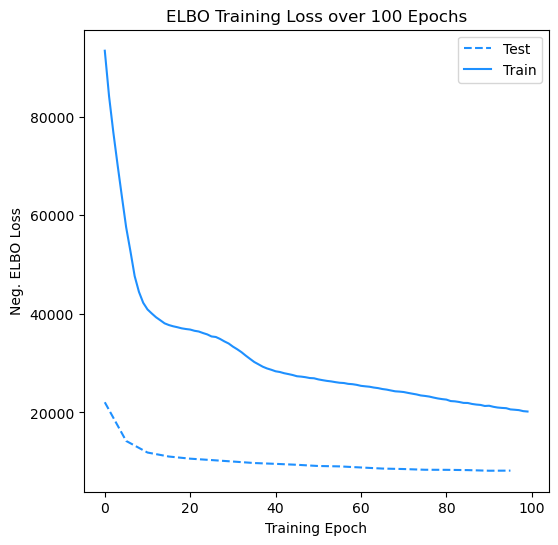

In [6]:
# lineplot for training and testing ELBOs
fig, ax = plt.subplots(1,1, figsize=(6,6))
plt.plot([i*5 for i in range(len(test_elbo))], -1*test_elbo, color='dodgerblue', linestyle='--', label='Test')
plt.plot(-1*train_elbo, color='dodgerblue', label='Train')
ax.set_xlabel('Training Epoch')
ax.set_ylabel('Neg. ELBO Loss')
ax.legend()
ax.set_title('ELBO Training Loss over {} Epochs'.format(len(train_elbo)));

print('Last Test ELBO Value: {:,.1f}'.format(test_elbo[-1]))

## Evaluate Reconstruction Accuracy

In [7]:
# reconstruct all of our sequences using the VAE to encode and then decode
data = torch.load(data_dir + f'data_{paralogs}.pt')
reconstructions = torch.zeros(data.shape)
for i, row in enumerate(data):
    reconstructions[i,:] = torch.round(vae.reconstruct(row))   # due to numerical artifacts, reconstruction is not all 0s and 1s


# compare each reconstructed sequence to its original
accuracy = reconstructions == data
print('Mean sequence percent match: {:.2f}%'.format(
    # calculate a total accuracy score
    100 * len(accuracy.nonzero()) / (data.shape[0]*data.shape[1])
))

Mean sequence percent match: 92.32%


/var/folders/47/14w93qyx7xj7xrsd5bd9sfqr0000gp/T/ipykernel_32828/1359707676.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(data_dir + f'data_{paralogs

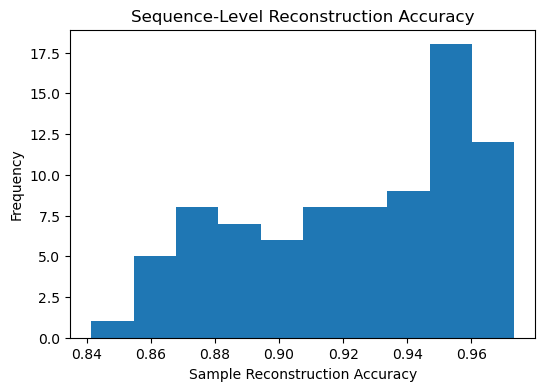

In [8]:
# plot a histogram of per-sequence reconstruction accuracies
samplewise_accuracy = []
for row in accuracy:
    samplewise_accuracy.append(len(row.nonzero()) / row.shape[0])
    
fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.hist(samplewise_accuracy)
ax.set_xlabel('Sample Reconstruction Accuracy')
ax.set_ylabel('Frequency')
ax.set_title('Sequence-Level Reconstruction Accuracy');

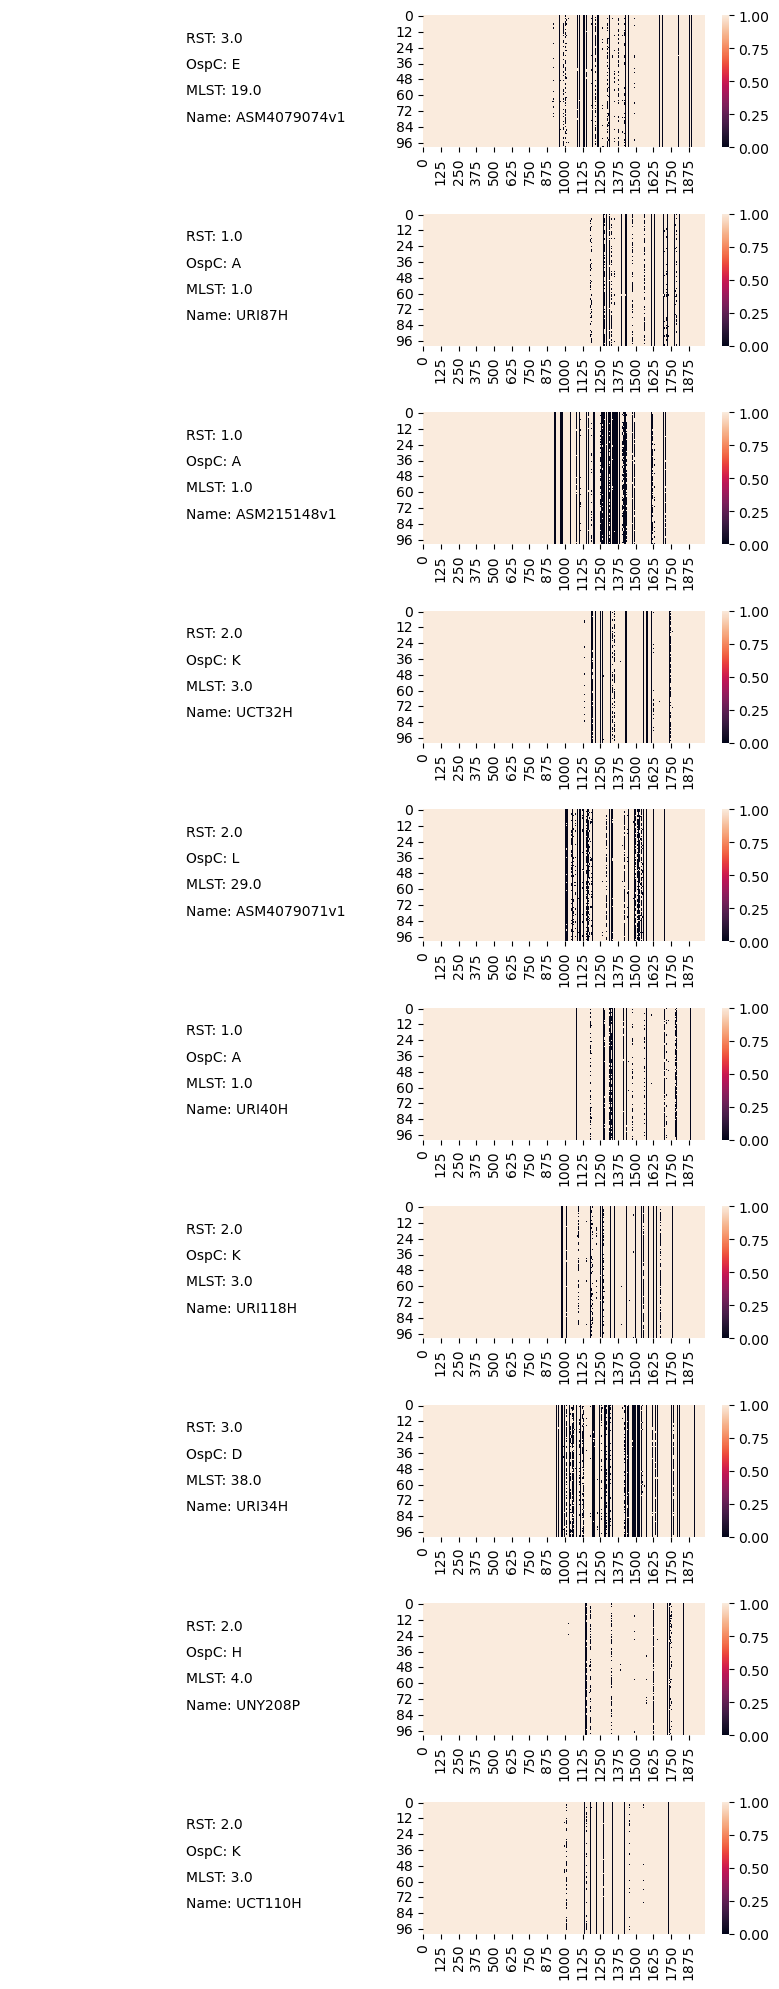

In [9]:
# sample a selection of sequences to reconstruct
random.seed(1)
n = 10
idxs = random.sample(range(data.shape[0]), n)
samples = data[idxs]

# get labels for these samples
labels = pd.read_csv(data_dir + f'labels.csv')
sample_labels = labels.iloc[idxs]

# set the number of desired reconstructions
n_reconstructions = 100

fig, axes = plt.subplots(n, 2, figsize=(8, 2*n))
for i in range(n):
    l = sample_labels.iloc[i]
    axes[i, 0].text(0.5, 0.8, 'RST: {}'.format(l['RST']))
    axes[i, 0].text(0.5, 0.6, 'OspC: {}'.format(l['OspC']))
    axes[i, 0].text(0.5, 0.4, 'MLST: {}'.format(l['MLST']))
    axes[i, 0].text(0.5, 0.2, 'Name: {}'.format(l['Isolate']))
    axes[i, 0].axis('off')
    
    ax = axes[i, 1]
    s = samples[i]
    match = torch.zeros(n_reconstructions, s.shape[0])
    # iterate through multiple reconstructions for a given sequence
    for j in range(n_reconstructions):
        match[j] = torch.round(vae.reconstruct(s)) == s
    # plot a heatmap showing correspondence between each reconstructed sequence and the original
    sns.heatmap(match, ax=ax)  
fig.tight_layout()

## PCA Analysis

In [10]:
# fit a two dimensional PCA on the latent space
n_components = 2
pca = PCA(n_components=n_components)
pca.fit([vae.encode(s)[0].detach().numpy() for s in data])

PCA(n_components=2)

In [11]:
# set up color palettes for plotting
rst_palette = {1: "#FF0000",
               2: "#00FF00",
               3: "#0000FF"}
ospc_palette = dict(zip(sorted(labels["OspC"].unique()), sns.color_palette("husl", len(labels["OspC"].unique())).as_hex()))
mlst_palette = dict(zip(sorted(labels["MLST"].unique()), sns.color_palette("hls", len(labels["MLST"].unique())).as_hex()))


In [12]:
# function for creating scatterplots of the principal components
def encoding_scatterplot(data, labels, genotype: str, ax):
    if genotype=="RST":
        palette=rst_palette
    elif genotype=="OspC":
        palette=ospc_palette
    elif genotype=="MLST":
        palette=mlst_palette
    else:
        ValueError('Genotype must be "RST", "OspC", or "MLST"')
    assigned = ~labels[genotype].isna()
    genotype_labels = labels[genotype][assigned]
    idxs = assigned.index[assigned].tolist()

    # get loc of sequence encoding
    encoding_locs = torch.zeros(len(idxs), z_dim)
    for i, s in enumerate(data[idxs, :]):
        z_loc, _ = vae.encode(s)
        encoding_locs[i] = z_loc
        
    # transform the encodings of annotated samples to principal components
    encoding_pca = pca.transform(encoding_locs.detach().numpy())

    # sort PCs by genotype for plotting
    sorted_genotype = sorted(zip(genotype_labels, encoding_pca), key=lambda x: x[0] if str(x[0]).isnumeric() else np.inf)
    sorted_labels = [i[0] for i in sorted_genotype]
    sorted_pcs = np.array([i[1] for i in sorted_genotype])
    PC1 = sorted_pcs[:, 0]
    PC2 = sorted_pcs[:, 1]

    # scatterplot
    sns.scatterplot(x=PC1, y=PC2, hue=sorted_labels, palette=palette, ax=ax,
                alpha=0.75)
    legend_handles = [mpatches.Patch(color=color, label=f'{p}') for p, color in palette.items()]
    ax.legend(handles=legend_handles,
              title=genotype,
              loc="upper left",
                ncol=1,
                fontsize=8,
                bbox_to_anchor=(1,1))
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_title(f'{genotype} Clusters in the Latent Space')


## Figure 7a

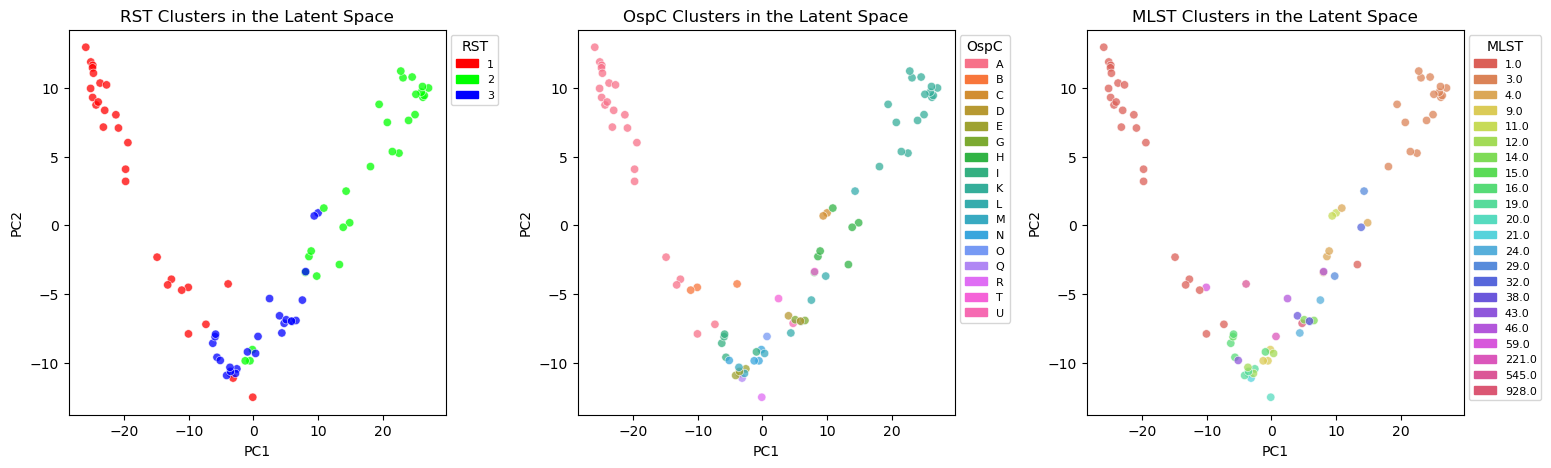

In [13]:
fig, ax = plt.subplots(ncols=3,nrows=1,figsize=(18,5))
encoding_scatterplot(data, labels, "RST", ax[0])
encoding_scatterplot(data, labels, "OspC", ax[1])
encoding_scatterplot(data, labels, "MLST", ax[2])
plt.subplots_adjust(wspace=0.35)  

## Genome Reconstruction

In [14]:
# specify the genotype for analysis
gt = "RST"

In [15]:
# load in data
full = pd.read_pickle(data_dir + input_file)
data = torch.load(data_dir + vaedata_file)
labels = pd.read_csv(data_dir + vaelabels_file)

identifiers = ["Isolate", "RST", "OspC", "MLST"]
gt_presence = pd.concat([full[gt], full.drop(columns=identifiers)], axis=1)
gt_presence


/var/folders/47/14w93qyx7xj7xrsd5bd9sfqr0000gp/T/ipykernel_32828/1613064034.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(data_dir + vaedata_file)


,RST,group_1286,perM,fmhB,ispA,ruvB,group_171,group_170,potD,mreB,...,group_1314,group_1304,group_1310,aph3Ia,group_1309,group_1308,group_1306,aac3Ia,group_1305,group_23
0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
78,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
80,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# extract list of gene groups
gene_groups = [c for c in full.columns if c not in identifiers]

In [17]:
# append the specified genotype onto the presence / absence data
genotype_presence = pd.concat([full[gt], full.drop(columns=identifiers)], axis=1)
genotype_presence.head()

,RST,group_1286,perM,fmhB,ispA,ruvB,group_171,group_170,potD,mreB,...,group_1314,group_1304,group_1310,aph3Ia,group_1309,group_1308,group_1306,aac3Ia,group_1305,group_23
0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
# encode all genotype-labeled samples into the latent space
gt_assigned = ~labels[gt].isna()
gt_labels = labels[gt][gt_assigned]
idxs = gt_assigned.index[gt_assigned].tolist()

embedding_locs = torch.zeros(len(idxs), z_dim)

for i, s in enumerate(data[idxs, :]):
    z_loc, _ = vae.encode(s)
    embedding_locs[i] = z_loc

In [19]:
# extract the latent space embeddings as a dataframe
dim = ["z"+str(x) for x in range(1,z_dim+1)]
embedding_df = pd.DataFrame(embedding_locs.detach().numpy(), columns=dim)
sampling = pd.concat([gt_labels, embedding_df], axis=1)
sampling = sampling.sort_values(by=gt, ascending=True).reset_index(drop=True)
sampling.head()

,RST,z1,z2,z3,z4,z5,z6,z7,z8,z9,...,z23,z24,z25,z26,z27,z28,z29,z30,z31,z32
0,1.0,-0.028978,11.409966,-0.093789,-0.009430,7.978157,8.702788,-0.275774,16.360044,7.931674,...,-0.049410,-0.056669,-0.173043,-0.242838,-0.044839,-0.051789,-0.095784,3.135095,-0.018153,-0.046730
1,1.0,-0.031938,12.888542,-0.038251,-0.011800,10.022499,7.549204,-0.262555,9.999866,6.777330,...,-0.030274,-0.040276,-0.164571,-0.202283,-0.017844,-0.054777,-0.093955,1.482474,-0.016545,-0.028729
2,1.0,-0.029369,10.881872,-0.076374,-0.009685,8.194441,8.756910,-0.270052,14.479212,7.724806,...,-0.044626,-0.052120,-0.172481,-0.230148,-0.028016,-0.052974,-0.095136,2.240080,-0.022432,-0.043778
3,1.0,-0.032513,12.271815,-0.044212,-0.013363,9.522670,7.741459,-0.261835,10.076397,6.825343,...,-0.030192,-0.039708,-0.166779,-0.201021,-0.020607,-0.056312,-0.091535,1.331322,-0.017018,-0.031957
4,1.0,-0.032565,9.841592,-0.062112,-0.002556,6.769972,6.190533,-0.276768,17.059597,6.178374,...,-0.057366,-0.060716,-0.153634,-0.253339,-0.019942,-0.047484,-0.095432,3.923619,-0.004942,-0.051765


In [20]:
# obtain the mean and standard deviation of the latent space encodings for each genotype
gt_types = sampling[gt].drop_duplicates().reset_index(drop=True)
sampling_means = pd.concat([gt_types, sampling.groupby([gt]).transform("mean").drop_duplicates().reset_index(drop=True)], axis=1)
sampling_stdev = pd.concat([gt_types, sampling.groupby([gt]).transform("std").drop_duplicates().reset_index(drop=True)], axis=1)
stdev_means = sampling_stdev.drop(columns=gt).mean(skipna=True)
sampling_stdev = sampling_stdev.fillna(stdev_means)


In [21]:
unique_gt_types = sampling[gt].unique()
unique_gt_types

array([1., 2., 3.])

In [22]:
def reconstruct_gt_sequence(g):
    # select the genotype to generate a sequence for
    gt_type = g

    # get the corresponding row from the dataframe of means and standard deviations
    mean_row = sampling_means[sampling_means[gt] == gt_type].iloc[0]
    std_row = sampling_stdev[sampling_stdev[gt] == gt_type].iloc[0]

    # extract mean and std values for the latent dimensions
    means = mean_row[1:]
    stds = std_row[1:]

    # generate samples from a normal distribution with the appropriate parameters
    z = torch.tensor(np.random.normal(means, stds), dtype=torch.float32)
    
    # decode from the latent space
    s = torch.round(vae.decoder(z)).detach().numpy()
    return s


In [23]:
# function to generate multiple sequences at once
def reconstruct_mlst_matrix(gs):
    output = np.empty((0, len(gene_groups)))
    for g in gs:
        if g in unique_gt_types:
            s = np.array(reconstruct_gt_sequence(g))
            output = np.vstack((output, s))
        else:
            continue
    output = pd.DataFrame(output, columns=gene_groups)
    return output    
        

In [24]:
# example for generating 82 sequences based on genotype
reconstruct_mlst_matrix(full[gt])

,group_1286,perM,fmhB,ispA,ruvB,group_171,group_170,potD,mreB,dppC,...,group_1314,group_1304,group_1310,aph3Ia,group_1309,group_1308,group_1306,aac3Ia,group_1305,group_23
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
78,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
80,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
def calculate_reconstruction_accuracy(g):
    # generate a single sequence based on genotype
    z = reconstruct_gt_sequence(g)
    # extract data on all isolates of that same genotype
    gt_subset = gt_presence[gt_presence[gt]==g].drop(columns=[gt]).values
    # compare the generated sequence to isolate data
    diff = abs(gt_subset - z) == 0
    # calculate accuracy based on matched positions
    acc = np.mean((np.sum(diff, axis=1))/len(gene_groups))*100
    return acc

def plot_reconstruction_accuracy(g):
    # compare generated sequence to isolates of that genotype
    z = reconstruct_gt_sequence(g)
    gt_subset = gt_presence[gt_presence[gt]==g].drop(columns=[gt]).values
    h = gt_subset.shape[0]
    diff = abs(gt_subset - z) == 0
    acc = np.mean((np.sum(diff, axis=1))/len(gene_groups))*100
    
    # plot matches and mismatches as heatmap
    fig, ax = plt.subplots(figsize=(15,h/15))
    sns.heatmap(diff, ax=ax, cbar=False)
    ax.set_title(f"{gt} Type {g}: Reconstruction vs Isolates ({acc:.2f}% Accuracy)")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.savefig(f"../4_results/{gt}/ReconstructionAccuracy_{g}.jpg", bbox_inches="tight")
    return acc


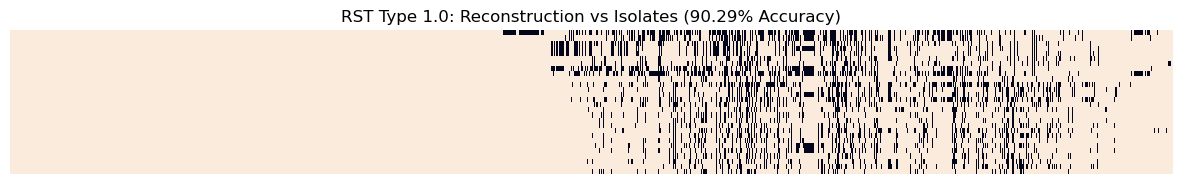

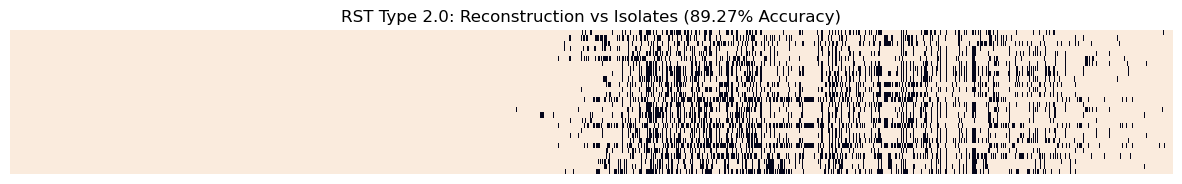

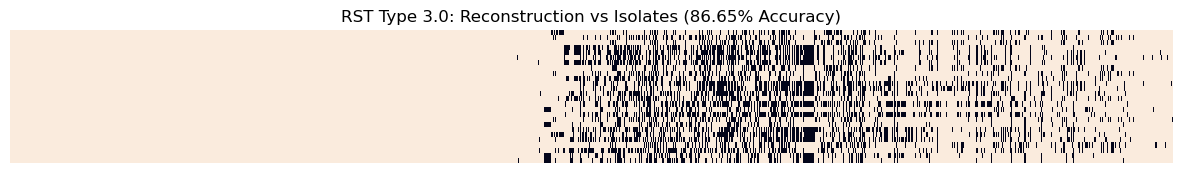

In [26]:
# reconstruction accuracy plots for each genotype
accuracy_results = []
for g in unique_gt_types:
    x = plot_reconstruction_accuracy(g)
    accuracy_results.append(x)

In [27]:
# iterative version of the reconstruction accuracy calculations for bootstrapping
def accuracy_bootstrapping(g, n):
    accuracy_results = []
    for i in range(0,n):
        x = calculate_reconstruction_accuracy(g)
        accuracy_results.append(x)
    return accuracy_results   

In [28]:
# set color dictionary
if gt=="RST":
    color_dict = rst_palette
elif gt=="OspC":
    color_dict = ospc_palette
elif gt=="MLST":
    color_dict = mlst_palette
else:
    print("Need a valid genotype.")

1.0 89.75094902581064
2.0 89.74150190524121
3.0 86.32731214432272


Text(0.5, 1.0, 'Sequence Reconstruction Accuracy by RST')

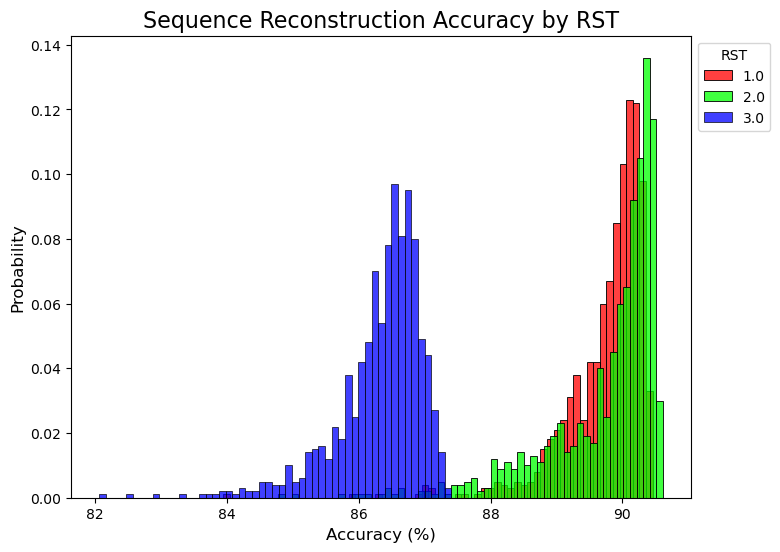

In [29]:
# plot histogram of bootstrapped reconstruction accuracy 
fig, ax = plt.subplots(figsize=(8,6))
for g in unique_gt_types:
    accuracy_results = accuracy_bootstrapping(g, 1000)
    score = np.mean(accuracy_results)
    print(g, score)
    sns.histplot(accuracy_results, ax=ax, binwidth=0.1, stat="probability", label=g, color=color_dict[g])
if gt=="MLST":
    ax.legend(title=f"{gt}",
          loc="upper left",
          bbox_to_anchor=(1,1),
          ncol=2)
else:
    ax.legend(title=f"{gt}",
            loc="upper left",
            bbox_to_anchor=(1,1))
    
ax.set_xlabel("Accuracy (%)", fontsize=12)
ax.set_ylabel("Probability", fontsize=12)
ax.set_title(f"Sequence Reconstruction Accuracy by {gt}", fontsize=16)